# PSTAT131 Final Project
Sean Gao, Aya Zeplovitch

## Introduction 

This project aims to predict the number of comments given the question of any [r/Askreddit](https://www.reddit.com/r/AskReddit/) question. r/Askreddit is a forum where redditors (Reddit users) post questions (about anything really). We try to find the answer to the following question: "what kind of r/Askreddit questions garner the most interactions?" This is an interesting question because as someone that regularly browses Reddit, there definitely exists a pattern between the posts that become popular.

***

## NLP

As our data is going to be text data, we will have to use NLP techniques to transform text into machine readable dataframes. The most common techniques used are word-embedding, and bag-of-words. Here's approximately how they work:

Suppose we have the following sentence: *"I like my big pancakes"*

We can make our list of vocabulary from this sentence: **'I', 'like', 'my', big', 'pancakes'**. Both techniques uses the one-hot (or multi-hot in the case of bag-of-words) encoding (i.e., the word 'like' would be represented by a vector **[0, 1, 0, 0, 0]**). 

###  Word-embedding

In the case of word-embedding, a $m \times n$ matrix will be created, where $m$ is the number of words in the sentence, and $n$ is the number of words in our total vocabulary. As such, our sentence will be represented as such:

||I|like|my|big|pancakes|
|---|---|---|---|---|---|
|1|1|0|0|0|0|
|2|0|1|0|0|0|
|3|0|0|1|0|0|
|4|0|0|0|1|0|
|5|0|0|0|0|1|

### Bag-of-words

In the case of bag-of-words, a single array of length $m$ will be created. The value at each index will be the number of occurrences of the word that index represents. With the same vocabulary, *'I like pancakes.'* would be represented as such:

|I|like|my|big|pancakes|
|---|---|---|---|---|
|1|1|0|0|1|

### Word-embedding vs bag-of-words

Word-embedding holds more information than bag-of-words. For one, one sentence is represented as an $m \times n$ matrix with word-embedding, whereas it is represented as a $m$ size array with bag-of-words. Most importantly, word-embedding is able to represent the order of the words in the sentence. For example, take the phrases "yeah no" and "no yeah." To a fluent English speaker, they have opposite meanings: "yeah no" means "no," and "no yeah" means "yes." However, they would have the same representation with the bag-of-words technique, whereas word-embedding would be able to properly represent the difference between these phrases. 

However, word-embedding is much more computationally expensive as each sentence would be $n$ times bigger. It also requires a different type of algorithm to model as each sentence would have a different $n$, making the number of predictors variable. As such, common machine learning methods like linear regression, ensemble tree methods, and many others would not work with the data. This is one reason we have decided to go with the bag-of-words approach. Another reason is that due to the nature of what we're trying to predict, the order of the words in the question may not matter as much as which words actually appear in the question. 


***

## Importing packages

All the imports will be grouped at the top, make sure they are all installed and up to date if you're trying to run this notebook. This was bulit on Python 3.10~. 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from tqdm import tqdm

*** 

## Notebook parameters

Some parameters here to help run the notebook faster. Our dataset is huge so it helps to only use portions of it for the sake of memory/computing power

We were actually unable to use the entire dataset (nearly 1 million rows) as we lacked the memory. The number of words in the vocabulary was very important as well both for predictability and computational power. The N_VOCAB value we chose was mainly as a result of limited computational power and memory.

**PCT_DATA**: the percentage of the entire dataset used for the rest of the notebook.  
**N_VOCAB**: the number of words in the vocabulary 

In [49]:
PCT_DATA = .1
N_VOCAB = 1000

*** 

## Helper functions

Each function will have Docstrings included to describe its purpose and usage

In [50]:
def rm_stop(words):
    """
    Removes the stopwords from a list of words
    """

    new_words = []
    stop_words = nltk.corpus.stopwords.words('english')

    for w in words:
        if w not in stop_words:
            new_words.append(w)
    return new_words

def build_data(pct_data=PCT_DATA):
    """
    Uses data/finaldataset.csv to create a text dataset.
    Result dataset will contain a string with stop words removed.
    """

    raw_df = pd.read_csv('data/finaldataset.csv')
    raw_df = raw_df.iloc[:round(raw_df.shape[0] * pct_data)]

    # num_comments is self explanatory, title is the question (our predictor)
    df = raw_df[['num_comments', 'title']]
    del raw_df

    # setting all strings to lowercase and tokenizing them
    df.loc[:,'title'] = df['title'].str.lower()
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')
    df.loc[:,'tokenized'] = df['title'].apply(tokenizer.tokenize)

    # removing stop words and rejoining the words for CountVectorizer later
    df['tokenized'] = df['tokenized'].apply(rm_stop)
    df['text'] = df['tokenized'].apply(lambda x: ' '.join([word for word in x]))

    return df

def fit_n_vocab(df, n_vocab=N_VOCAB):
    """
    Fits the bag-of-words with N_VOCAB as the number of words in the vocabulary. 

    Returns:
    --------
        X : np.array()
            Number of observations x N_VOCAB bag-of-words matrix
        Y : np.array()
            Array containing the number of comments
        vocab : np.array()
            Array of strings of the vocab
        vectorizer: CountVectorizer()
            CountVectorizer object used to transform new data
    """

    vectorizer = CountVectorizer(max_features=n_vocab)
    vecfit = vectorizer.fit_transform(df['text'])
    X = vecfit.toarray()

    vocab = vectorizer.get_feature_names()
    Y = df['num_comments'].to_numpy()

    return X, Y, vocab, vectorizer 

def pct_no_words(X):
    """Calculates the percent of observations with 0 words in the bag-of-words"""
    return sum(np.sum(X, axis=1) > 0)/X.shape[0]

def pred_from_str(q, m, vec):
    """Uses any model m to predict the number of comments of string q"""
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    q = tokenizer.tokenize(q)
    q = rm_stop(q)

    j = lambda x: ' '.join([word for word in x])
    q = j(q)
    pred_X = vec.transform(pd.Series(q)).toarray()

    pred = m.predict(pred_X)

    return pred

***

## Our data

Our data is gathered from the third party Reddit API [pushshift](https://pushshift.io/). The code for our data gathering can be found in our Github repo [here](https://github.com/seangao14/pstat131proj). Since the data collection and processing could take hours, we will include the link to the dataset [here](https://drive.google.com/drive/folders/1cTAwppo6BCP_D0SbrmyKpjrwZvwvVm2H?usp=sharing). The file we are using is *finaldataset.csv*.  
The API did not yield the correct number of upvotes, which is why we're using the number of comments as our target variable. The number of comments or upvotes both show the popularity of the post, which is why we deemed the number of comments to be a sufficient replacement for the number of upvotes.


If you're trying to run this notebook, be sure to have your *finaldataset.csv* in a folder named "data", such that the file path from this file would be ***data/finaldataset.csv***.

In [51]:
df = build_data()
X, Y, vocab, vectorizer = fit_n_vocab(df=df, n_vocab=N_VOCAB)
del df

/Users/ayazeplovitch/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (7,8,61,62,66,67,70,71,72,73,74,75) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


***

## EDA

There are two main things we want to accomplish with EDA: the most practical N_VOCAB value and the best transformation for our target variable.  

First we construct a graph plotting the number of vocabulary against the percentage of observations with at least 1 word in the bag-of-words (the horizontal sum of each observation is at least 1). This is important because having no word in the bag-of-words essentially means the data has no information regarding that observation. As such, we want to minimize the number of observations which the model learns nothing about. With our limited computational power, we are unable to have a large amount of vocabularies in our bag-of-words.  

If you're running this from a cloned repo from our [Github](https://github.com/seangao14/pstat131proj), you won't need to change anything to run this next code block, as *pct_df.csv* is included in the repo. Otherwise, set **run** to **True** if it is your first time running this notebook, **False** otherwise.

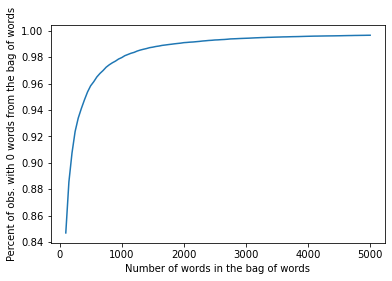

In [5]:
# set run = True if first time running, False otherwise as it takes a while (upwards of an hour on some machines) to run
run = False

if run:
    pct_vals = []
    df = build_data()

    for i in tqdm(np.arange(100, 5001, 50)):
        X = fit_n_vocab(df=df, n_vocab=i)[0]
        pct = pct_no_words(X)
        pct_vals.append([i, pct])
    pct_df = pd.DataFrame(pct_vals, columns=['n_vocab', 'pct_words'])
    pct_df.to_csv('pct_df.csv')
else:
    pct_df = pd.read_csv('pct_df.csv')

plt.plot(pct_df['n_vocab'], pct_df['pct_words'])
plt.xlabel('Number of words in the bag of words')
plt.ylabel('Percent of obs. with 0 words from the bag of words')

plt.show()

We can see that there is a diminishing return effect once N_VOCAB reaches about the 1000 mark, so we will use a value within that range. We realize that this is not a perfect solution as about 2% of the observations will have no information about them. However, with our limited compute we believe this is the best compromise.  

Next we will plot a histogram of our target variable, to see if any transformations should be made. We expect that the data will be positively skewed, as most of the posts on r/Askreddit garner little attention, and a few posts get most of the comments.

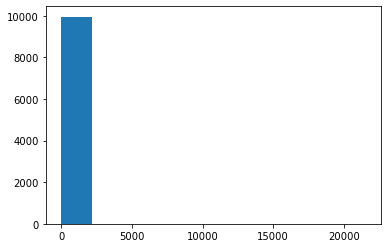

In [6]:
plt.hist(Y)
plt.show()

This plot basically meets our expectation of an extreme positive skewness. Let's bound the x-values and increase the number of bins.

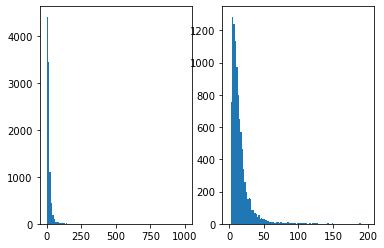

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(Y, bins=100, range=(0, 1000))
ax[1].hist(Y, bins=100, range=(0, 200))
plt.show()

The skewness exists even when we set the upper bound to 200. A good transformation for skewed data is a log transform, so we will do that.

In [8]:
# Y transformation
log_Y = np.log(Y, dtype=float)

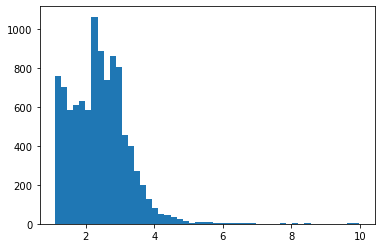

In [10]:
plt.hist(log_Y, bins=50)
plt.show()

We can see that the data is now much more normally distributed, although there still exists a positive skew. For the most part, this transformed Y is normal enough for the assumption of normality in models like linear regression.

***

## Train, Validation, Test Data Split

In [52]:
df = pd.DataFrame(data = X)
df['Y'] = Y

# splitting the data into train and the remaining data
X_train = df.sample(frac = 0.8, random_state = 25)  # random_state serves as a seed
X_remaining = df.drop(X_train.index)

Y_train = X_train.pop('Y')

#splitting the remaining data into validation and test
X_val = X_remaining.sample(frac = 0.5, random_state = 25)
X_test = X_remaining.drop(X_val.index)

Y_val = X_val.pop('Y')
Y_test = X_test.pop('Y')


print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of validation examples: {X_validation.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

del df, X_remaining

No. of training examples: 79822
No. of validation examples: 998
No. of testing examples: 9977


In [53]:
from scipy import stats

# code from: https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
def make_lr_dict(m, y, p):
    params = np.append(linReg.intercept_,linReg.coef_)
    predictions = p

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    return myDF3.drop([0])

In [54]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression().fit(X_train, np.log(Y_train))
lin_ypred = linReg.predict(X_train)
print(mean_squared_error(Y_train, np.exp(lin_ypred)))

scorelin = cross_val_score(LinearRegression(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scorelin.mean())

265731.4975700375
268513.54968645575


In [55]:
lin_ypredval = linReg.predict(X_val)
print(mean_squared_error(Y_val, np.exp(lin_ypredval)))

525517.5680249324


In [56]:
lr_df = make_lr_dict(linReg, Y_train, np.exp(lin_ypred))
lr_df['word'] = vocab
lr_df.sort_values(by=['Coefficients'], ascending=False)

,Coefficients,Standard Errors,t values,Probabilities,word
723,0.7912,43.864,0.018,NaN,rittenhouse
927,0.7800,29.656,0.026,NaN,username
384,0.4791,45.630,0.010,NaN,gun
472,0.4596,44.791,0.010,NaN,kyle
626,0.4588,33.283,0.014,NaN,penis
...,...,...,...,...,...
59,-0.4254,46.543,-0.009,NaN,artists
826,-0.4302,12.979,-0.033,NaN,story
825,-0.4411,31.713,-0.014,NaN,stories
541,-0.4899,44.485,-0.011,NaN,meme


In [57]:
# define transform
for i in range(1, 11):
    n_components = int(N_VOCAB * 0.1*i)
    pca = PCA(n_components = n_components)
    # prepare transform on dataset
    pca.fit(X_train)
    # apply transform to dataset
    transformed = pca.transform(X_train)
    
    linReg_pca = LinearRegression().fit(transformed, np.log(Y_train))
    lin_ypred_pca = linReg_pca.predict(transformed)
    mse = mean_squared_error(Y_train, np.exp(lin_ypred_pca))
    print("# of components", n_components, "MSE =", mse)

# of components 100 MSE = 265823.858645234
# of components 200 MSE = 265801.5538549158
# of components 300 MSE = 265792.23739489826


KeyboardInterrupt: 

In [40]:
transformed.shape

(7982, 50)

In [41]:
X_train.shape

(7982, 100)

In [43]:
linReg_pca = LinearRegression().fit(transformed, np.log(Y_train))
lin_ypred = linReg_pca.predict(transformed)
print(mean_squared_error(Y_train, np.exp(lin_ypred)))


225573.02213844785


In [42]:
from sklearn.ensemble import RandomForestRegressor

randForest = RandomForestRegressor().fit(X_train, Y_train)
scores = cross_val_score(randForest, X_train, Y_train, cv = 5)
scores

array([ -0.5747165 ,  -0.08465526,  -0.05039692, -15.05224579,
        -3.76181467])

In [ ]:
df

In [16]:
from sklearn.linear_model import Lasso

lassoReg = Lasso().fit(X_train, Y_train)
lassoReg.score(X_train, Y_train)

0.0

In [56]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge().fit(X_train, Y_train)
ridge_ypred = ridgeReg.predict(X_train)
print(mean_squared_error(Y_train, ridge_ypred))

scoreridge = cross_val_score(Ridge(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreridge.mean())

0.6763387097664976
0.6939658846812932


In [60]:
import statsmodels.api as sm

ols = sm.OLS(Y_train, X_train)
ols_fit = ols.fit()

ols_ypred = ols_fit.predict(X_train)
print(mean_squared_error(Y_train, ols_ypred))

2.828248869367714


In [59]:
del ols
del ols_fit

In [43]:
from sklearn.neural_network import MLPRegressor

mlpReg = MLPRegressor(max_iter = 500, random_state = 1).fit(X_train, Y_train)
#print(mlpReg.score(X_train, Y_train))

ypred = mlpReg.predict(X_train)
print(mean_squared_error(Y_train, ypred))

scoreMLP = cross_val_score(MLPRegressor(max_iter = 500, random_state = 1), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreMLP.mean())



0.4232551898203105
0.9373989289273446


In [52]:
from sklearn.neighbors import KNeighborsRegressor

kReg = KNeighborsRegressor().fit(X_train, Y_train)
k_ypred = kReg.predict(X_train)
print(mean_squared_error(Y_train, k_ypred))

scoreK = cross_val_score(KNeighborsRegressor(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreK.mean())



0.7199426985446578
0.8282334772548527


In [19]:
X_train.shape, Y_train.shape

((159644, 500), (159644,))

In [20]:
X_test.shape, Y_test.shape

((39911, 500), (39911,))